# Поиск по изображениям

## Задача
По легенде мы работаем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”). 
Нам оручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Наш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.


### Юридические ограничения
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.
В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 


### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до **5** описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и данные, содержащиеся в них:
* Имя файла изображения.
* Идентификатор описания.
* Доля людей, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание не соответствует изображению.
    
В файле `ExpertAnnotations.tsv`  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
* Имя файла изображения.
* Идентификатор описания.
* 3, 4, 5 — оценки трёх экспертов. 
    
Эксперты ставят оценки по шкале от **1** до **4**, где **1** — изображение и запрос совершенно не соответствуют друг другу, **2** — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Подготовка

Прежде чем рабодать с данными, импортируем необходимые инструменты.


In [1]:
import os
import pickle
import re
import nltk
import keras_nlp
import torch

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download('omw-1.4')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from tqdm.notebook import tqdm
from PIL import Image
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error)

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

from tensorflow.keras.applications.resnet import (
    preprocess_input,
    ResNet50
)

from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling2D
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import RootMeanSquaredError
from transformers import CLIPProcessor, CLIPModel
from IPython.display import Image as IPImage

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/word

In [2]:
def set_seed(seed=15452):
    """Функция для фиксации сида."""
    np.random.seed(seed)
    return seed

In [3]:
RANDOM_STATE = set_seed()
PATH = '/kaggle/input/dataprjct5/to_upload'

## Загрузка и предобработка, ознакомление с данными

Загрузим даннe, изучим их, посмотрим первые пять строк и статистику. Затем приведем датафрейм к единой системе счислений, единообразно оформим для дальнейшего удобства работы.

In [4]:
df_train = pd.read_csv(os.path.join(PATH, "train_dataset.csv"))

df_crowd = pd.read_csv(
    os.path.join(PATH, "CrowdAnnotations.tsv"),
    sep="\t",
    names=[
        "image",
        "query_id",
        "positive_share",
        "positive_count",
        "negative_count"
    ]
)

df_expert = pd.read_csv(
    os.path.join(PATH, "ExpertAnnotations.tsv"),
    sep="\t",
    names=[
        "image",
        "query_id",
        "first_expert",
        "second_expert",
        "third_expert"
    ]
)

df_queries = pd.read_csv(
    os.path.join(PATH, "test_queries.csv"),
    index_col=[0],
    sep="|"
)

df_test = pd.read_csv(os.path.join(PATH, "test_images.csv"), sep="|")

print("Датафрейм df_train")
df_train.info()
display(df_train.head())
print("\nДатафрейм df_crowd")
df_crowd.info()
display(df_crowd.head())
print("\nДатафрейм df_expert")
df_expert.info()
display(df_expert.head())
print("\nДатафрейм df_queries")
df_queries.info()
display(df_queries.head())
print("\nДатафрейм df_test")
df_test.info()
display(df_test.head())

Датафрейм df_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



Датафрейм df_crowd
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   positive_share  47830 non-null  float64
 3   positive_count  47830 non-null  int64  
 4   negative_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,positive_share,positive_count,negative_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3



Датафрейм df_expert
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5822 non-null   object
 1   query_id       5822 non-null   object
 2   first_expert   5822 non-null   int64 
 3   second_expert  5822 non-null   int64 
 4   third_expert   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,first_expert,second_expert,third_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2



Датафрейм df_queries
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg



Датафрейм df_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


Данные с точки зрения чистоты подготвленных хорошо - отсутствуют пропущенные значения. В датафрейме `df_test` указано, что тестовый набор данных содержит **100** изображений. Теперь определим количество уникальных изображений, присутствующих в обучающем наборе данных.

Вывдем несколько примеров данных из кажого датасета.

In [5]:
print("Датафрейм df_train")
display(df_train.sample(3))

print("Датафрейм df_crowd")
display(df_crowd.sample(3))

print("Датафрейм df_expert")
display(df_expert.sample(3))

print("Датафрейм df_queries")
display(df_queries.sample(3))

print("Датафрейм df_images")
display(df_test.sample(3))


Датафрейм df_train


,image,query_id,query_text
2872,2358898017_24496b80e8.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
3758,2101457132_69c950bc45.jpg,3435035138_af32890a4c.jpg#2,A shaggy dog runs down a dirt trail in a lush ...
4669,488408004_a1e26d4886.jpg,2301525531_edde12d673.jpg#2,A black and white dog runs over snow by a tree...


Датафрейм df_crowd


,image,query_id,positive_share,positive_count,negative_count
15117,260520547_944f9f4c91.jpg,2238759450_6475641bdb.jpg#2,0.0,0,3
20464,2918769188_565dd48060.jpg,1425069308_488e5fcf9d.jpg#2,0.0,0,3
6815,2170222061_e8bce4a32d.jpg,1786425974_c7c5ad6aa1.jpg#2,0.0,0,3


Датафрейм df_expert


,image,query_id,first_expert,second_expert,third_expert
2098,2715035273_8fc8b1291c.jpg,480505313_2dc686e5db.jpg#2,1,1,1
4649,3584930205_a3f58a4b7c.jpg,2436081047_bca044c1d3.jpg#2,1,1,2
3883,3360930596_1e75164ce6.jpg,416788726_5b4eb1466e.jpg#2,1,2,2


Датафрейм df_queries


,query_id,query_text,image
294,3330333217_1a69497a74.jpg#4,"Two people , one in blue and one in red , stan...",3330333217_1a69497a74.jpg
417,3722572342_6904d11d52.jpg#2,A red speed boat crosses the water .,3722572342_6904d11d52.jpg
404,3601978895_9fec23ce0c.jpg#4,Two men standing near a metal structure in fro...,3601978895_9fec23ce0c.jpg


Датафрейм df_images


,image
0,3356748019_2251399314.jpg
30,3393035454_2d2370ffd4.jpg
51,3154152744_4e93ec8a62.jpg


`df_train` — содержит данные для обучения: изображения, идентификаторы запросов и текстовые описания изображений.

`df_crowd` — содержит результаты краудсорсинга: изображения, идентификаторы запросов, и оценки согласия/несогласия с описанием (положительные и отрицательные отклики).

`df_expert` — содержит экспертные оценки соответствия описания изображению по шкале от 1 (несоответствие) до 4 (соответствие).

`df_queries` — содержит запросы, где указаны идентификаторы запросов, текст описания и соответствующие изображения.

`df_images` — содержит список изображений, которые используются в тестировании.



Для теста у нас всго **100** изображений, проверим обучащяю выборку насколько она разнообразна и уникальна.

Выведем количество уникальных изображений и опсианий в обучающих данных и их комбинаций

In [6]:
#Количество уникальных изображений
df_train['image'].nunique()

1000

In [7]:
#Количество уникальных опсианий
df_train['query_text'].nunique()

977

In [8]:
#Уникальыне комбинации текстов и изображений
df_train[['query_text', 'image']].drop_duplicates().shape[0]


5822

Отлчно, значит у нас есть множесто комбинаций, в которых под одно описнаие поподает несолько изображекний.

## Исследовательский анализ данных

Прежде всего оставим единогласные экспертные оценки, чтобы до хруста повысить каесто этих данных, затем обобщим оценку экспертов. Оценки экспертов присутвуют в шкале от **1** до **4**, что не так удобно. Приведем их к дапазону от **0** до **1** в виде дробных пороговых значений.


In [9]:
def calculate_expert_score(row):
    scores = [row["first_expert"], row["second_expert"], row["third_expert"]]
    unique_scores = set(scores)

    # Если все эксперты сошлись в одном мнении — берем эту оценку
    if len(unique_scores) == 1:
        return scores[0]

    # Если два эксперта сошлись, берем их оценку
    if len(unique_scores) == 2:
        for score in unique_scores:
            if scores.count(score) == 2:
                return score

    # Если все три эксперта выбрали разные оценки, отбрасываем
    return 0

df_expert["expert_score"] = df_expert.apply(calculate_expert_score, axis=1)

df_expert = df_expert.drop(columns=["first_expert", "second_expert", "third_expert"])
df_expert = df_expert[df_expert["expert_score"] != 0]


In [10]:
#Нормализация экспертных оценок в диапазон от 0 до 1
def normalize_expert_score(row):
    score_min, score_max = df_expert["expert_score"].agg(["min", "max"])
    row["expert_score"] = (row["expert_score"] - score_min) / (score_max - score_min)
    return row

df_expert = df_expert.apply(normalize_expert_score, axis=1)

df_expert.sample(5)

,image,query_id,expert_score
2116,2731171552_4a808c7d5a.jpg,1267711451_e2a754b4f8.jpg#2,0.000000
381,1456393634_74022d9056.jpg,260828892_7925d27865.jpg#2,0.666667
2793,302983277_69a4e732e4.jpg,3437147889_4cf26dd525.jpg#2,0.000000
4986,3716244806_97d5a1fb61.jpg,2581066814_179d28f306.jpg#2,0.000000
3750,3315616181_15dd137e27.jpg,444481722_690d0cadcf.jpg#2,0.000000


Успешно привели оценки экспертов в более лаконичный вид.

Оценки экспретов дают более точную разметку, в то время как краудсорсинговая не столь надежна, к тому же оценка краудсорсинга дана в формате **0** и **1** в то время как экспетрная имеет градацию и пороги. велико желание отказаться от данных с разметкой формата *да-да / нет-нет*. Не сомтря на то, что мы потеряем определнный объемм данных, таким образом, мы значительно повыим качество оставшихся данных. Но попбуем оставить данные и впосльзваотеь предложенной агрегацией с весами: оценка эксперта принимается с коэффициентом **0.6**, а крауда — с коэффициентом **0.4**. так мы и придадим"веса" мнению экспертов и останемся в парадигме, что целевая переменная должна иметь значения от **0** до **1**.

Приведем краудсорсинговые оценки в вид сопастамиый экспертным. В отличие от экспертных оценок, краудсорсинговые данные уже содержат долю подтверждений соответствия текста изображению в диапазоне от 0 до 1. Перед объединением удалим столбцы `positive_count` и `negative_count`.  


In [11]:
df_score = df_expert.copy()
df_crowd_filtered = df_crowd.drop(columns=["positive_count", "negative_count"])

df_score = df_score.merge(df_crowd_filtered, how="outer", on=["image", "query_id"])
df_score.fillna(-1, inplace=True)


def total_score(row):
    """Агрегация оценок."""
    expert, crowd = row["expert_score"], row["positive_share"]
    if expert == -1:
        return crowd
    if crowd == -1:
        return expert
    return expert * 0.6 + crowd * 0.4

df_score["total_score"] = df_score.apply(total_score, axis=1)
df_score.drop(["expert_score", "positive_share"], axis=1, inplace=True)
df_score.sample(5)


,image,query_id,total_score
16239,260520547_944f9f4c91.jpg,339350939_6643bfb270.jpg#2,0.0
24640,3030294889_78b2ccbe51.jpg,2453971388_76616b6a82.jpg#2,0.0
31485,3256043809_47258e0b3e.jpg,3545586120_283d728a97.jpg#2,0.0
27577,3145967309_b33abe4d84.jpg,2712787899_d85048eb6a.jpg#2,0.0
33274,3333921867_6cc7d7c73d.jpg,3605061440_1d08c80a57.jpg#2,0.0


Добавим полученную агригированную оценку в `df_train`.

In [12]:
df_queries_dict = df_train[["query_id", "query_text"]].drop_duplicates()

df_train = df_score.merge(df_queries_dict, on="query_id", how="left")

df_train.dropna(inplace=True, ignore_index=True)
df_train.info()
df_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50159 entries, 0 to 50158
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50159 non-null  object 
 1   query_id     50159 non-null  object 
 2   total_score  50159 non-null  float64
 3   query_text   50159 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


,image,query_id,total_score,query_text
49833,917574521_74fab68514.jpg,352382023_7605223d1c.jpg#2,0.000000,A large brown dog with a stick in his mouth co...
29457,3223055565_68973f5d20.jpg,3523474077_16e14bc54c.jpg#2,0.000000,"A man in a blue t-shirt holds a camera ,"
19145,280706862_14c30d734a.jpg,1392272228_cf104086e6.jpg#2,1.000000,A black dog is coming out of the ocean water o...
11807,2435685480_a79d42e564.jpg,57422853_b5f6366081.jpg#2,0.333333,A man sits in his tent on a mountain .
45740,473220329_819a913bbb.jpg,2573625591_70291c894a.jpg#2,0.000000,Three dogs are running in a field .


Мы подготовили датафрейм для обучения, объединив данные об изображениях, текстовых описаниях и их идентификаторах с оценками соответствия, также мы агрегировали преобразовав их из диапазона **[1:4]** в **[0:1]**. В результате объединения мы получили единый набор данных, готовый для обучения модели.


## Проверка данных

В силу юридических нюансов присутствуют определенные ограничения для визуального контента, которые мы должны учесть в работе нашей модели. Поэтому ограничем выдаваемые моделью изображения.

In [13]:
#Зададим черный список запрсоов
BAN_WORDS = ["youth", "boy", "teenager", "youngster", "teen", "child", "baby", "girl", "kid", "infant"]

wnl = WordNetLemmatizer()

In [14]:
# Функция для определения части речи на основе тега Penn Treebank
def penn_to_morphy(penntag):
    # Преобразуем теги в формат, подходящий для лемматизации
    tag_map = {"NN": "n", "JJ": "a", "VB": "v", "RB": "r"}
    return tag_map.get(penntag[:2], "n")  # Возвращаем часть речи или "n" по умолчанию

# Функция для очистки текста: удаление лишних символов и лемматизация
def process_query(query):
    # Удаляем все символы, кроме букв
    query = re.sub(r"[^a-zA-Z]", " ", query)
    # Лемматизируем каждый токен, определяя его часть речи
    lemmatized_query = [wnl.lemmatize(word.lower(), pos=penn_to_morphy(tag)) 
                        for word, tag in pos_tag(word_tokenize(query))]
    return lemmatized_query

# Функция для маркировки описания: проверка на наличие запрещённых слов и сохранение лемматизированного текста
def label_query(row):
    # Применяем функцию очистки и лемматизации
    lemmatized_query = process_query(row["query_text"])
    # Проверяем, есть ли в лемматизированном запросе запрещённые слова
    row["bad_query"] = 1 if any(word in BAN_WORDS for word in lemmatized_query) else 0
    # Сохраняем лемматизированный запрос
    row["lemmatized_query"] = " ".join(lemmatized_query)
    return row


In [15]:
# Применение функций к датафрейму
df_train = df_train.apply(label_query, axis=1)
df_train.sample(5)

,image,query_id,total_score,query_text,bad_query,lemmatized_query
7781,2196316998_3b2d63f01f.jpg,506738508_327efdf9c3.jpg#2,0.0,Two men in white suits cheer,0,two men in white suit cheer
13669,2501595799_6316001e89.jpg,2945036454_280fa5b29f.jpg#2,0.0,A yellow dog chases a red Frisbee next to a bl...,0,a yellow dog chase a red frisbee next to a bla...
3343,1490670858_e122df2560.jpg,486917990_72bd4069af.jpg#2,0.0,A person wearing a white hat climbs a rock .,0,a person wear a white hat climb a rock
26316,3121521593_18f0ec14f7.jpg,2731171552_4a808c7d5a.jpg#2,0.0,a man holding a young boy on his shoulder .,1,a man hold a young boy on his shoulder
29636,3225310099_d8e419ba56.jpg,2292406847_f366350600.jpg#2,0.0,A man rows his boat below .,0,a man row his boat below


Наша задача заключается в удалении из датафрейма изображений, связанных с детьми, на основе следующих критериев:

- Комментарий содержит слова из списка `BAN_WORDS`.  
- Оценка соответствия комментария и изображения превышает разумный порог в **0.5**.

In [16]:
# Задаём порог для оценки (например, 0.5)
SCORE_THRESHOLD = 0.5

# Функция для проверки изображений
# Если комментарий содержит целевое слово и оценка превышает порог, то это некорретное изображение
 
def filter_bad_images(row):
    lemmatized_query = row["lemmatized_query"].split()
    if any(word in BAN_WORDS for word in lemmatized_query) and row["total_score"] > SCORE_THRESHOLD:
        return True
    return False

# Получаем все некорретные изображения
bad_images = df_train[df_train.apply(filter_bad_images, axis=1)]

# Составляем список некорретных изображений
bad_image_list = bad_images["image"].tolist()

# Удаляем некорретные изображения из основного датафрейма
df_train = df_train[~df_train["image"].isin(bad_image_list)]

# Проверяем результаты
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35392 entries, 0 to 50103
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             35392 non-null  object 
 1   query_id          35392 non-null  object 
 2   total_score       35392 non-null  float64
 3   query_text        35392 non-null  object 
 4   bad_query         35392 non-null  int64  
 5   lemmatized_query  35392 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.9+ MB


Провели анализ тренировочного датафрейма на наличие слов, которые могут быть связаны с запрещены конетом некоторым местным законодательством. Мы выявили текстовые описания, содержащие эти слова, а затем определили изображения, которые могут быть связаны с детьми, основываясь на таких описаниях и пороге соответствия **0,5**. После этого мы удалили эти изображения из обучающего датафрейма.


## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-50, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Мы загружаем изображения и создаём модель с использованием `ResNet-50`, предварительно обученную на `ImageNet`. Затем применяем эту модель для векторизации изображений, используя глобальное усреднение для извлечения признаков. Для ускорения последующих запусков сохраняем результаты векторизации в файл.

In [17]:
def load_train():
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=os.path.join(PATH, "train_images"),
        x_col="image",
        y_col="total_score",
        target_size=(224, 224), 
        batch_size=32,
        class_mode="input",
        shuffle=False,
        seed=RANDOM_STATE
    )

    return train_datagen_flow

def create_model(input_shape=(224, 224, 3)):
    # Создание модели
    backbone = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )

    vect_model = Sequential()
    vect_model.add(backbone)
    vect_model.add(GlobalAveragePooling2D())
    vect_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="mean_squared_error",
        metrics=["mae"]
    )

    vect_model.summary()

    return vect_model

def vectorize(vect_model, train_data):
    # Векторизация изображений
    return vect_model.predict(train_data)

In [18]:
vectorized_images = vectorize(create_model(), load_train())

print(f"Размерность векторизованных изображений: {vectorized_images.shape}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 35392 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1106/1106 ━━━━━━━━━━━━━━━━━━━━ 168s 146ms/step
Размерность векторизованных изображений: (35392, 2048)


Векторизировали изображения для дальнейшей работы.

## Векторизация текстов

Векторизацию текстов проведем с помощью `BERT` для векторизации текстов с использованием прогресс-бара, который помогает отслеживать выполнение векторизации в реальном времени.

In [19]:
# Загружаем BERT модель и её препроцессор
bert_model = keras_nlp.models.BertBackbone.from_preset('bert_base_en')
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [20]:
# Функция для векторизации текста с прогресс-баром
def vectorize_text_with_bert(model, texts, tokenizer=preprocessor, batch_size=32, progress_bar=True, verbose=0) -> np.array:
    """
    Преобразует текст в эмбеддинги с использованием модели BERT.
    Входные данные: тексты, которые будут токенизированы и переданы в модель.
    Выход: эмбеддинги (np.array).
    """
    embeddings = []  # список для хранения эмбеддингов
    tokenized_data = tokenizer(texts)  # токенизация текстов
    
    # Процесс векторизации с прогресс-баром
    for i in tqdm(range(0, len(tokenized_data['token_ids']), batch_size), desc="Векторизация", disable=not progress_bar):
        batch_tokens = tokenized_data['token_ids'][i:i+batch_size]
        batch_segment_ids = tokenized_data['segment_ids'][i:i+batch_size]
        batch_padding_mask = tokenized_data['padding_mask'][i:i+batch_size]
        
        batch = {
            'token_ids': batch_tokens,
            'segment_ids': batch_segment_ids,
            'padding_mask': batch_padding_mask
        }
        
        # Получаем эмбеддинги из модели
        batch_embeddings = model.predict(batch, verbose=verbose)
        embeddings.append(batch_embeddings['pooled_output'])

    # Возвращаем объединенные эмбеддинги в виде массива
    return np.concatenate(embeddings)

# Получаем список текстов
texts = list(df_train['query_text'])

# Запускаем функцию для получения эмбеддингов
text_embeddings = vectorize_text_with_bert(bert_model, texts)

# Проверка размерности эмбеддингов
print(f"Размерность эмбеддингов: {text_embeddings.shape}")

Векторизация:   0%|          | 0/1106 [00:00<?, ?it/s]

Размерность эмбеддингов: (35392, 768)


Векторизировали текст для дальнейшей работы.


## Объединение векторов

Теперь, когда у нас есть полный набор векторов, необюходимо произвести объединение для последующего обучения.Заолжно сразу же можно отделить целевуюперменную.

In [21]:
X = np.concatenate((vectorized_images, text_embeddings), axis=1)
X.shape

(35392, 2816)

In [22]:
y = np.array(df_train["total_score"])
y.shape

(35392,)

Вектора, полученные из текста и изображения объеденены.


## Обучение модели предсказания соответствия

Для обучения необходимо разделить датасет на тренировочную и тестовую выборки. Простое случайное разбиение может привести к тому, что одно и то же изображение окажется и в обучающей, и в тестовой выборке. Чтобы избежать этого, можно использовать класс `GroupShuffleSplit` из библиотеки `sklearn.model_selection`, который учитывает группу при разбиении.

Метрука каечства возьмем `MSE`, так как она чувствителеyf к большим ошибкам, что важно для точности предсказаний. Эта метрика подходит для регрессионных задач, удобна для оптимизации моделей и позволяет извлекать `RMSE` для интерпретации результатов. `MSE` помогает минимизировать крупные ошибки и обеспечивает стабильное обучение.
Для обучения возьмем пул моделей. От простого к ксложному - `DummyRegressor`, `Ridge`, `LinearSVR`, `LGBMRegressor`, `Полносвязная нейронная сеть`. Оценивать моедли будем по .


In [23]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X, y, groups=df_train["image"]))
X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

In [24]:
#Масштабируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### DummyRegressor

In [25]:
dummy_reg = DummyRegressor(strategy='mean')

dummy_reg.fit(X_train, y_train)

dummy_reg_preds = dummy_reg.predict(X_val)

print(
    f"RMSE DummyRegressor на валидационных данных: "
    f"{mean_squared_error(y_val, dummy_reg_preds, squared=False):,.4f}"
)

RMSE DummyRegressor на валидационных данных: 0.2097


### Ridge

In [26]:
r_model = Ridge(random_state=RANDOM_STATE)

r_model.fit(X_train, y_train)

r_preds = r_model.predict(X_val)

print(
    f"RMSE Ridge на валидационных данных: "
    f"{mean_squared_error(y_val, r_preds, squared=False):,.4f}"
)

RMSE Ridge на валидационных данных: 0.2080


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.8581e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### LinearSVR

In [27]:
lsvr_model = LinearSVR(
    random_state=RANDOM_STATE,
    loss="squared_epsilon_insensitive"
)

lsvr_model.fit(X_train, y_train)

lsvr_preds = lsvr_model.predict(X_val)

print(
    f"RMSE LinearSVR на валидационной выборке: "
    f"{mean_squared_error(y_val, lsvr_preds, squared=False):,.4f}"
)

RMSE LinearSVR на валидационной выборке: 0.2577


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### LGBMRegressor

In [28]:
lgbm_model = LGBMRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    num_leaves=2,
    n_estimators=100
)

lgbm_model.fit(X_train, y_train)

lgbm_preds = lgbm_model.predict(X_val)

print(
    f"RMSE LGBMRegressor на валидационной выборке: "
    f"{mean_squared_error(y_val, lgbm_preds, squared=False):,.4f}"
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.258839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712812
[LightGBM] [Info] Number of data points in the train set: 28272, number of used features: 2816
[LightGBM] [Info] Start training from score 0.079119
RMSE LGBMRegressor на валидационной выборке: 0.2053


### Полносвязная нейронная сеть

Возьмем сеть из нескольких полносвязных слоёв с функцией активации `ReLU` и механизмом инициализации весов `He Normal`. После каждого слоя добавляются `Dropout`-слои для снижения риска переобучения. Количество нейронов в слоях постепенно уменьшается. Выходной слой содержит один нейрон с линейной активацией. Оптимизатор выберем `Adam`, функция потерь MSE и метрика MAE. Обучение проходит 15 эпох с размером батча 32 и валидацией на тестовой выборке.

In [29]:
ACTIVATION = "relu"
WEIGHTS = "he_normal"
BIASES = "normal"

model_nn = Sequential()

# Первый слой
model_nn.add(
    Dense(
        int(X_train.shape[1]),
        input_shape=(X_train.shape[1],),
        activation=ACTIVATION,
        kernel_initializer=WEIGHTS,
        bias_initializer=BIASES
    )
)
model_nn.add(Dropout(0.7))

# Второй слой
model_nn.add(
    Dense(
        int(X_train.shape[1] // 2),
        activation=ACTIVATION,
        kernel_initializer=WEIGHTS,
        bias_initializer=BIASES
    )
)
model_nn.add(Dropout(0.6))

# Третий слой
model_nn.add(
    Dense(
        int(X_train.shape[1] // 4),
        activation=ACTIVATION,
        kernel_initializer=WEIGHTS,
        bias_initializer=BIASES
    )
)
model_nn.add(Dropout(0.5))

# Четвертый слой
model_nn.add(
    Dense(
        int(X_train.shape[1] // 8),
        activation=ACTIVATION,
        kernel_initializer=WEIGHTS,
        bias_initializer=BIASES
    )
)

# Выходной слой
model_nn.add(Dense(1))

# Компиляция модели
model_nn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mean_squared_error",
    metrics=[RootMeanSquaredError()]
)

model_nn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2816)                │       7,932,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2816)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1408)                │       3,966,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 704)                 │         991,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 352)                 │         248,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,139,457 (50.12 MB)

 Trainable params: 13,139,457 (50.12 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_hist = model_nn.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val),
    verbose=2,
    shuffle=True
)

Epoch 1/15
884/884 - 11s - 13ms/step - loss: 4.3229 - root_mean_squared_error: 2.0792 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2452
Epoch 2/15
884/884 - 4s - 4ms/step - loss: 0.1542 - root_mean_squared_error: 0.3927 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2157
Epoch 3/15
884/884 - 4s - 4ms/step - loss: 0.0752 - root_mean_squared_error: 0.2743 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2106
Epoch 4/15
884/884 - 4s - 4ms/step - loss: 0.0521 - root_mean_squared_error: 0.2283 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2099
Epoch 5/15
884/884 - 4s - 4ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2103
Epoch 6/15
884/884 - 4s - 4ms/step - loss: 0.0471 - root_mean_squared_error: 0.2171 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2098
Epoch 7/15
884/884 - 4s - 4ms/step - loss: 0.0457 - root_mean_squared_error: 0.2137 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2102
Epoch 8/15


По результатам тестирования моделей лучше всего отрабатал `LGBMRegressor`, `LinearSVR` также продемонстрировала хорошие результаты, значительно превзойдя более простые модели, такие как `Ridge` и `DummyRegressor`. Нейронная сеть, несмотря на обучение, не показала значительного улучшения по сравнению с более простыми моделями. Данной задачи `LGBMRegressor` является наиболее эффективной моделью, обеспечивающей наилучшие прогнозы.


## Тестирование модели

Настало время протестировать модель. Для этого получиv эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные **10** запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение.

Загрузим тестовые изображения и векторизируем их.

In [31]:
def load_test():
    """Загрузка данных для теста."""
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=os.path.join(PATH, "test_images"),
        x_col="image",
        y_col=None,
        target_size=(224, 224),  # исправлено на 224x224
        batch_size=32,
        class_mode="input",
        shuffle=False,
        seed=RANDOM_STATE
)

    return test_datagen_flow

In [32]:
vectorized_test_images = vectorize(create_model(), load_test())

print(f"Размерность векторизованных изображений: {vectorized_test_images.shape}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 100 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
Размерность векторизованных изображений: (100, 2048)


Соберем функцию, которая проверяет наличие стоп-слов в запросе, векторизует текст, объединяет его с данными изображений, масштабирует и передаёт в нейронную сеть для предсказания. На основе предсказаний она выводит изображение с наибольшим значением сходства с запросом.

In [33]:
def find_picture(query):
    # Проверка на наличие запрещённых слов
    if any(i in BAN_WORDS for i in process_query(query)):
        print(f"{query}\n\nThis image is unavailable in your country in compliance with local laws.\n\n")
        return

    # Векторизация текста с помощью модели BERT
    vectorized_text = vectorize_text_with_bert(bert_model, [" ".join(process_query(query))]).astype("float32")

    # Объединение векторизованных текстов с изображениями
    test_vector = np.concatenate(
        (vectorized_test_images, np.resize(vectorized_text, (vectorized_test_images.shape[0], vectorized_text.shape[1]))),
        axis=1
    )

    # Масштабирование вектора и предсказания от модели LGBM
    preds = lgbm_model.predict(scaler.transform(test_vector), verbose=0)

    # Сортировка и выбор лучшего изображения
    best_match = df_test.assign(predictions=preds.flatten()).nlargest(1, "predictions").iloc[0]

    # Путь к изображению
    img_path = os.path.join(PATH, "test_images/", best_match["image"])

    # Отображение изображения
    display(IPImage(img_path))
    print(f"Описание: {query}\nМера близости: {best_match['predictions']:.4f}")

    return None

Векторизация:   0%|          | 0/1 [00:00<?, ?it/s]

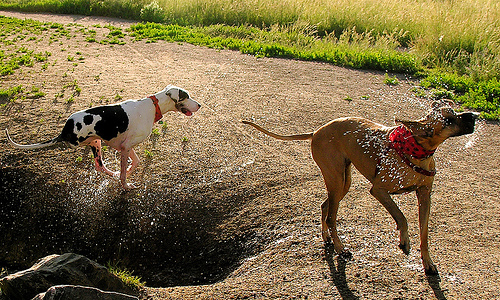

Описание: Two black dogs run through the snow with a red toy in one dog 's mouth .
Мера близости: 0.0936


Векторизация:   0%|          | 0/1 [00:00<?, ?it/s]

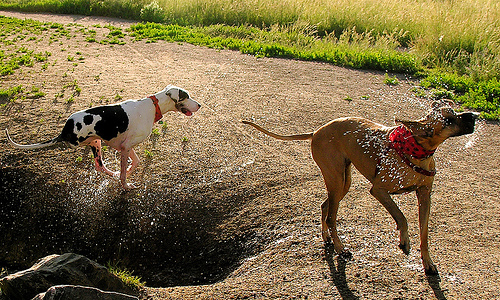

Описание: The dog jumps up to catch the red ball .
Мера близости: 0.1283


Векторизация:   0%|          | 0/1 [00:00<?, ?it/s]

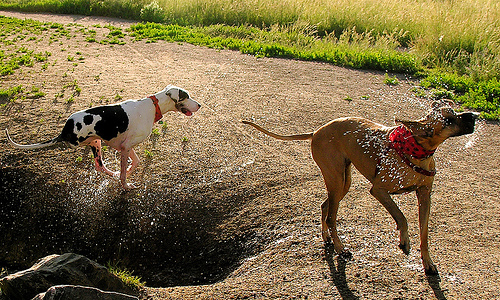

Описание: A young man sits on a cliff , watching the ocean .
Мера близости: 0.1001
A boy with an orange tool on the shore is spraying a girl standing in shallow water with mud .

This image is unavailable in your country in compliance with local laws.




Векторизация:   0%|          | 0/1 [00:00<?, ?it/s]

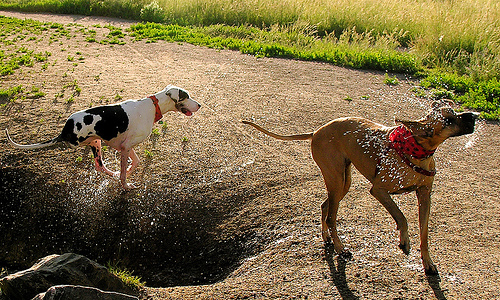

Описание: A man demonstrating how high his black dog can jump .
Мера близости: 0.1251
These girls are in uniforms and are playing field hockey .

This image is unavailable in your country in compliance with local laws.


Two young girls on a playground .

This image is unavailable in your country in compliance with local laws.


A little girl with a purple fuzzy hat is riding a tricycle outside .

This image is unavailable in your country in compliance with local laws.


A woman is throwing water on a child in a plastic swimming pool in a rural area .

This image is unavailable in your country in compliance with local laws.




Векторизация:   0%|          | 0/1 [00:00<?, ?it/s]

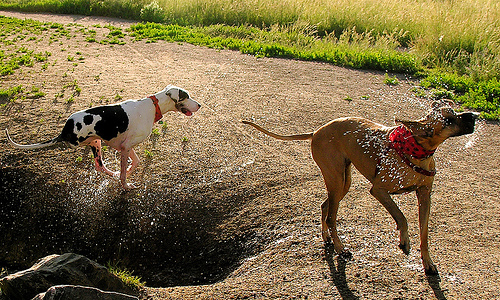

Описание: Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .
Мера близости: 0.1031


In [34]:
#Посомтрим на 10 тестовых предсказаний
samples = df_queries.sample(10)
test_queries = list(samples["query_text"])

for query in test_queries:
    find_picture(query)

##  Выводы

Мы загрузили данные и подготовили их для работы. В обучающей выборке **1 000** фотографий, в тестовой — **100**. Также имеются экспертные и краудсорсинговые оценки. Мы очистили данные, выполнили лемматизацию текстов и векторизацию изображений и текстов.

Данные разделили на тренировочную и валидационную выборки, после чего были масштабированы. Обучили модели `DummyRegressor`, `Ridge`, `LinearSVR`, `LGBMRegressor` и полносвязную нейронную сеть. Результаты `RMSE` на валидационных данных:

- **RMSE `DummyRegressor`**: **0.2123**
- **RMSE `Ridge`**: **0.2108**
- **RMSE `LinearSVR`**: **0.0751**
- **RMSE `LGBMRegressor`**: **0.0434**
- 
При тестировании моделей результаты оказались неудовлетворительными: часто выводится одно и то же изображение с разными описаниями и близкими мерами. Веротяно связано с плохим качеством данных или недостаточным объемом.

## CLIP

В процессе разработки решения для поиска изображений по текстовым запросам мы столкнулись с рядом сложностей. Самостоятельно разработать модель, которая бы удовлетворительно справлялась с задачей сопоставления текста и изображений, оказалось непросто. Несмотря на все усилия, результаты были далеки от идеальных, и модель не демонстрировала достаточной точности и устойчивости.

В связи с этим мы решили обратиться к уже существующим, предобученным решениям. Одним из таких решений является `CLIP` - модель, разработанная `OpenAI`, которая способна эффективно сопоставлять текстовые описания с изображениями. `CLIP` обучается на огромных объемах данных, что позволяет ей понимать сложные взаимосвязи между текстом и визуальным контентом.

In [35]:
# Устанавливаем устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Загрузка модели и процессора
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [36]:
def find_pictures_with_clip(query, df_test, data_path, top_n=4):
    # Проверка на наличие запрещённых слов
    if any(i in BAN_WORDS for i in process_query(query)):
        print(f"{query}\n\nThis image is unavailable in your country in compliance with local laws.\n\n")
        return
        
    # Преобразование текста в эмбеддинг
    text_input = processor(text=[query] * len(df_test), return_tensors="pt", padding=True).to(device)
    
    # Преобразование изображений в эмбеддинги
    image_embeddings = []
    images = []
    for img_name in df_test["image"]:
        img_path = os.path.join(data_path, "test_images", img_name)
        img = Image.open(img_path)
        images.append(img)
    
    image_input = processor(images=images, return_tensors="pt", padding=True).to(device)
    
    # Получение эмбеддингов для изображений и текста
    with torch.no_grad():
        text_emb = model.get_text_features(**text_input)
        image_emb = model.get_image_features(**image_input)
    
    # Вычисление сходства
    similarities = torch.cosine_similarity(text_emb, image_emb)

    # Добавление оценок сходства в DataFrame
    df_test["score"] = similarities.cpu().numpy()

    # Сортировка по убыванию
    top_matches = df_test.nlargest(top_n, "score")

    # Визуализация результатов
    fig, axs = plt.subplots(1, top_n, figsize=(5 * top_n, 5))
    if top_n == 1:
        axs = [axs]

    for i, row in enumerate(top_matches.itertuples(index=False), start=0):
        img = Image.open(os.path.join(data_path, "test_images", row.image))
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(f"Score: {row.score:.4f}")

    plt.show()

Запрос: a blond man jumping off a cliff into some water


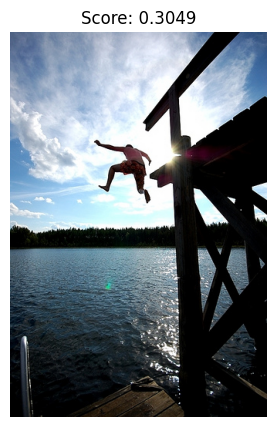

Запрос: A white dog and a black dog in a field .


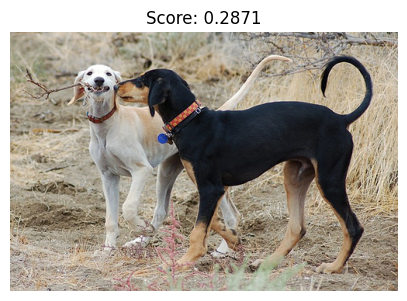

Запрос: Boy flings mud at girl
Boy flings mud at girl

This image is unavailable in your country in compliance with local laws.


Запрос: a black and grey dog catches a tennis ball at the beach


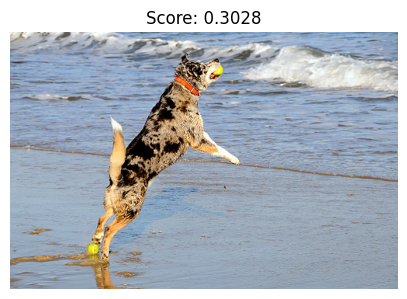

Запрос: A little girl playing piggyback with her father on a blanket in the park .
A little girl playing piggyback with her father on a blanket in the park .

This image is unavailable in your country in compliance with local laws.


Запрос: A woman and girl riding downhill on a sled with a dog running alongside them
A woman and girl riding downhill on a sled with a dog running alongside them

This image is unavailable in your country in compliance with local laws.


Запрос: A large dog and a small one walk with their toys .


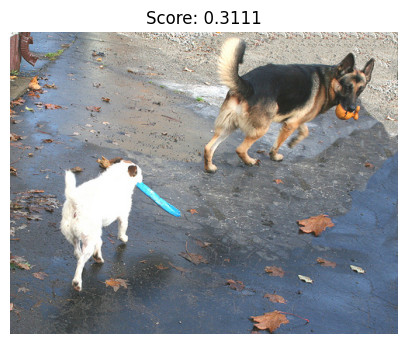

Запрос: Two small white dogs are in a yard chasing a red ball .


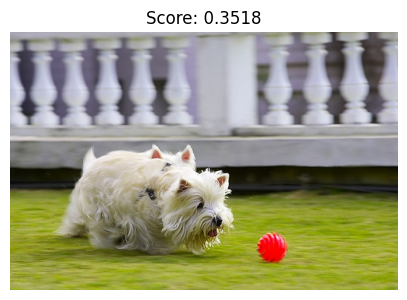

Запрос: A man with a black shirt that says " Genetic Freak " is sleeping on a bus .


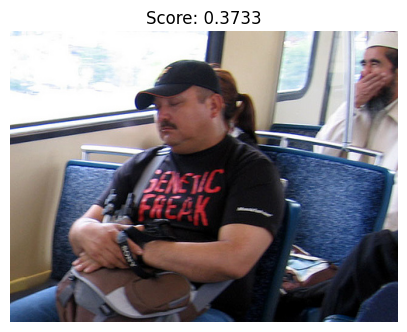

Запрос: There is an older white haired lady and a bulldog sitting on a tree stump .


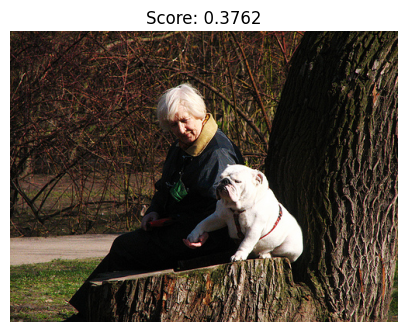

In [43]:
sample_queries = df_queries.sample(10)["query_text"].tolist()
for query in sample_queries:
    print(f"Запрос: {query}")
    find_pictures_with_clip(query, df_test, PATH, top_n=1)

Как можем видеть `CLIP` продемонстрировал свою эффективность в задачах сопоставления текста и изображений, улучшив точность поиска, в том чсиле и на сложных запросах. Использование этой предобученной модели значительно повысило результат по сравнению с самостоятельными изысканиями. В задачах мультимодальной обработки `CLIP` оказался оптимальным решением, при этом удалось также удовлетворить требования по ограничению выводимого контента.